# IMC-Denoise: a content aware denoising pipeline to enhance imaging mass cytometry

Here we will show an example for denoising the images with marker CD38 from our own human bone marrow IMC dataset.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tp
import os
from IMC_Denoise.IMC_Denoise_main.DIMR import DIMR
from IMC_Denoise.IMC_Denoise_main.DeepSNiF import DeepSNiF
from IMC_Denoise.DeepSNiF_utils.DeepSNiF_DataGenerator import DeepSNiF_DataGenerator

### Generate correct file structure for training
First, we will set up the file structure as described below. We will then randomly select one RoI per sample for training of DeepSNiF, since the validation and training is split automatically by the method and we want to avoid that there is a disbalance in ROI selection between samples.

In [1]:
import os
import tifffile
import xml
import pandas as pd
import io
import random
import shutil

def read_channel_names(path):
    
    tiff = tifffile.TiffFile(path)
    omexml_string = tiff.pages[0].description
    root = xml.etree.ElementTree.parse(io.StringIO(omexml_string))
    namespaces = {'ome': 'http://www.openmicroscopy.org/Schemas/OME/2016-06'}
    channels = root.findall('ome:Image[1]/ome:Pixels/ome:Channel', namespaces)
    channel_names = [c.attrib['Name'] for c in channels]
    return channel_names


base_path = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria"

BM_path = os.path.join(base_path, "BM")
out_path = os.path.join(base_path, "_Data_Analysis/_tmp_daria/Image_analysis/20230105_IMC-Denoise")
marker_codes = pd.read_csv(os.path.join(out_path, 'marker_codes.csv'), sep=";")

if not os.path.exists(os.path.join(out_path, "training")):
    os.mkdir(os.path.join(out_path, "training"))

if not os.path.exists(os.path.join(out_path, "other")):
    os.mkdir(os.path.join(out_path, "other"))

samples = os.listdir(BM_path)

for s in samples: 

    multichannel_path = os.path.join(BM_path, s, "IF_IMC_lowres")

    mc_image_files = os.listdir(multichannel_path)

    training_file = random.choice(mc_image_files)
    training_file = training_file.split(".")[0]


    for f in mc_image_files:
        file_name = f.split(".")[0]

        mc_image = tifffile.imread(os.path.join(multichannel_path, f))

        channel_names = read_channel_names(os.path.join(multichannel_path, f))
        channel_names = pd.DataFrame({'names':channel_names})
        channel_names = channel_names.replace(list(marker_codes["old_names"]), list(marker_codes["new_names"]))

        if file_name == training_file:
            folder = "training"
        else:
            folder = "other"

        if not os.path.exists(os.path.join(out_path, folder, file_name)):
            os.mkdir(os.path.join(out_path, folder, file_name))

        for c, img in enumerate(mc_image):
            tifffile.imwrite(os.path.join(out_path, folder, file_name, channel_names["names"][c]+".tiff"),img)


### Training data preparation
Next, we use our raw images to build a training set.
Note: 
1. The channel name must be consistant with the corresponding channel name in the image file names. For example, in our dataset, CD38 is conjucted with 141Pr. If the images with marker CD38 need to be denoised, the channel name will be set as its isotope name "141Pr".
2. Raw_directory is the folder of all the raw images used for generating training set. Its subfolders are the imagesets of different tissues. The subfolders contains the images from all the channels of the same tissue. <br>
<b>Data_structure example:
<br>|---Raw_image_directory
<br>|---|---Tissue1
<br>|---|---|---Channel1_img.tiff
<br>|---|---|---Channel2_img.tiff
<br>             ...
<br>|---|---|---Channel_n_img.tiff
<br>|---|---Tissue2
<br>|---|---|---Channel1_img.tiff
<br>|---|---|---Channel2_img.tiff
<br>             ...
<br>|---|---|---Channel_n_img.tiff
<br>             ...
<br>|---|---Tissue_m
<br>|---|---|---Channel1_img.tiff
<br>|---|---|---Channel2_img.tiff
<br>             ...
<br>|---|---|---Channel_n_img.tiff
</b>
3. n_neighbour and n_lambda are the parameters from DIMR algorithm for hot pixel removal in the training set generation process. 4 and 5 are their defaults. If the defaults are changed, the corresponding parameter should be declared in DeepSNiF_DataGenerator(). Otherwise, they can be omitted.
4. The DeepSNiF_DataGenerator class search all the CD38 images in raw image directory, split them into multiple 64x64 patches, and then augment the generated data. Note the very sparse patches are removed in this process.

In [5]:
# Release memory
if 'generated_patches' in globals():
    del generated_patches

channel_name = "89Y"
base_path = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria"
out_path = os.path.join(base_path, "_Data_Analysis/_tmp_daria/Image_analysis/20230105_IMC-Denoise")
Raw_directory = os.path.join(out_path, "training") # change this directory to your Raw_image_directory.

n_neighbours = 4 # Larger n enables removing more consecutive hot pixels. 
n_iter = 3 # Iteration number for DIMR
window_size = 3 # Slide window size. For IMC images, window_size = 3 is fine.

DataGenerator = DeepSNiF_DataGenerator(channel_name = channel_name, n_neighbours = n_neighbours, n_iter = n_iter, window_size = window_size)
generated_patches = DataGenerator.generate_patches_from_directory(load_directory = Raw_directory)
print('The shape of the generated training set is ' + str(generated_patches.shape) + '.')

Image data loaded from ...

/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/_Data_Analysis/_tmp_daria/Image_analysis/20230105_IMC-Denoise/training/20220223_07-1861_BM_R_ROI_003_IF_IMC/89Y-MPO_Y89.tiff
/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/_Data_Analysis/_tmp_daria/Image_analysis/20230105_IMC-Denoise/training/20220210_14-0025_BM_ROI_004_IF_IMC/89Y-MPO_Y89.tiff
/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/_Data_Analysis/_tmp_daria/Image_analysis/20230105_IMC-Denoise/training/20220215_18-3011_BM_ROI_003_IF_IMC/89Y-MPO_Y89.tiff
/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/_Data_Analysis/_tmp_daria/Image_analysis/20230105_IMC-Denoise/training/20211228_04-0968_BM_ROI_001_IF_IMC/89Y-MPO_Y89.tiff
/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/_Data_Analysis/_tmp_daria/Image_analys

### Show several generated patches of the training set

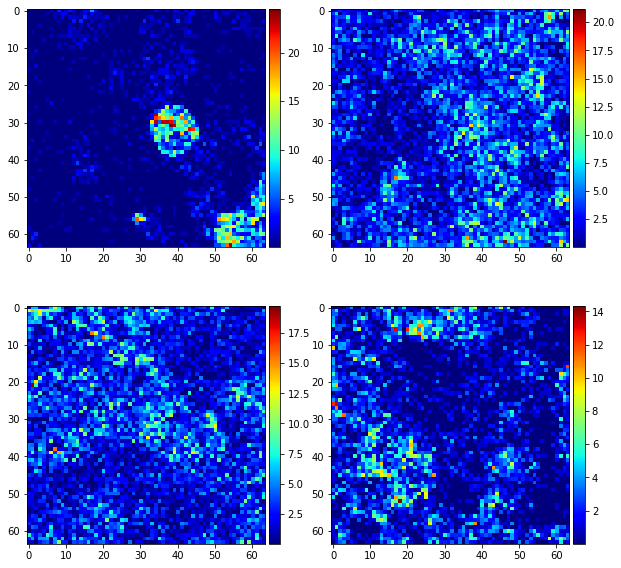

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(221)
im1 = ax1.imshow(generated_patches[0,:,:], cmap = 'jet')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(generated_patches[100,:,:], cmap = 'jet')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(generated_patches[1000,:,:], cmap = 'jet')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(generated_patches[-1,:,:], cmap = 'jet')
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical')

### DeepSNiF configuration and training
Define parameters for DeepSNiF training.

In [11]:
train_epoches = 3 # training epoches, which should be about 200 for a good training result. The default is 200.
train_initial_lr = 1e-3 # inital learning rate. The default is 1e-3.
train_batch_size = 256 # training batch size. For a GPU with smaller memory, it can be tuned smaller. The default is 256.
pixel_mask_percent = 0.2 # percentage of the masked pixels in each patch. The default is 0.2.
val_set_percent = 0.15 # percentage of validation set. The default is 0.15.
loss_function = "I_divergence" # loss function used. The default is "I_divergence".
weights_name = "weights.hdf5" # trained network weights saved here. If None, the weights will not be saved.
loss_name = "loss.npz" # training and validation losses saved here, either .mat or .npz format. If not defined, the losses will not be saved.
weights_save_directory = os.path.join(out_path, "results") # location where 'weights_name' and 'loss_name' saved.
# If the value is None, the files will be saved in a sub-directory named "trained_weights" of  the current file folder.
is_load_weights = False # True: load pre-trained weights file from disk for transfer learning and prediction. False: not load any pre-trained weights. 
lambda_HF = 3e-6 # HF regularization parameter
deepsnif = DeepSNiF(train_epoches = train_epoches, 
                  train_learning_rate = train_initial_lr,
                  train_batch_size = train_batch_size,
                  mask_perc_pix = pixel_mask_percent,
                  val_perc = val_set_percent,
                  loss_func = loss_function,
                  weights_name = weights_name,
                  loss_name = loss_name,
                  weights_dir = weights_save_directory, 
                  is_load_weights = is_load_weights,
                  lambda_HF = lambda_HF)

### Start training
If errors happen, check if the GPUs are being used by other sessions. If yes, shutdown the session occupying GPUs and re-run the prediction

In [12]:
train_loss, val_loss = deepsnif.train(generated_patches)

The range value to the corresponding model is 147.11868896484376.
Input Channel Shape => (169320, 64, 64, 1)
Number of Training Examples: 143922
Number of Validation Examples: 25398
Each training patch with shape of (64, 64) will mask 8 pixels.
Training model...
Epoch 1/3
563/563 [==============================] - 285s 506ms/step - loss: 0.0391 - val_loss: 0.0078

Epoch 00001: saving model to /data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/_Data_Analysis/_tmp_daria/Image_analysis/20230105_IMC-Denoise/results/weights.hdf5
Epoch 2/3
563/563 [==============================] - 269s 477ms/step - loss: 0.0055 - val_loss: 0.0054

Epoch 00002: saving model to /data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/_Data_Analysis/_tmp_daria/Image_analysis/20230105_IMC-Denoise/results/weights.hdf5
Epoch 3/3
563/563 [==============================] - 269s 477ms/step - loss: 0.0054 - val_loss: 0.0054

Epoch 00003: saving model

### Plot the training and validation losses

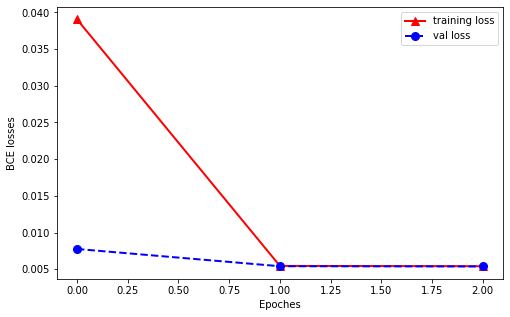

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(np.array(range(len(train_loss))),train_loss, color='red', marker='^', linewidth=2, markersize=8)
plt.plot(np.array(range(len(val_loss))),val_loss, color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=8)
plt.xlabel('Epoches')
plt.ylabel('BCE losses')
plt.legend(['training loss', 'val loss'])
plt.show()

### Load a raw CD38 image

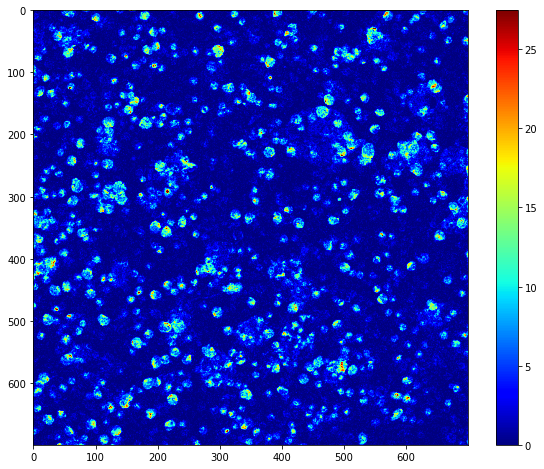

In [18]:
# read a CD38 raw image.
import random 

samples = os.listdir(os.path.join(out_path, "training"))
index = random.randrange(len(samples))
Raw_img_name = os.path.join(out_path, "training", samples[index], "89Y-MPO_Y89.tiff") # change to your raw image
Img_raw = tp.imread(Raw_img_name)
plt.figure(figsize = (10,8))
plt.imshow(Img_raw, vmin = 0, vmax = 0.5*np.max(Img_raw), cmap = 'jet')
plt.colorbar()
plt.show()

### Perform the DIMR algorithm only if the SNR of the raw image is high.

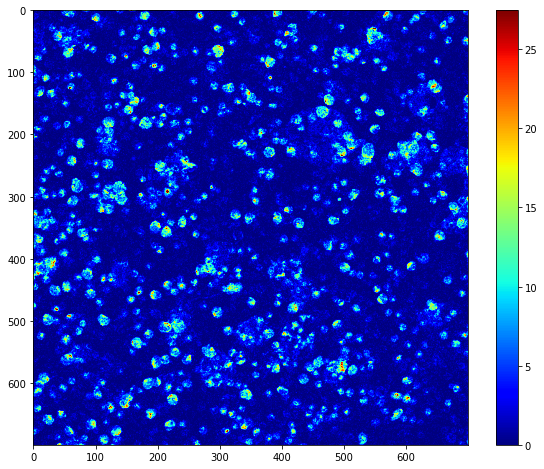

In [19]:
Img_DIMR = DIMR(n_neighbours = n_neighbours, n_iter = n_iter, window_size = window_size).perform_DIMR(Img_raw)
plt.figure(figsize = (10,8))
plt.imshow(Img_DIMR, vmin = 0, vmax = 0.5*np.max(Img_DIMR), cmap = 'jet')
plt.colorbar()
plt.show()

### If the SNR of the raw image is sub-optimal, perform DIMR and DeepSNiF algorithms for low SNR raw images.

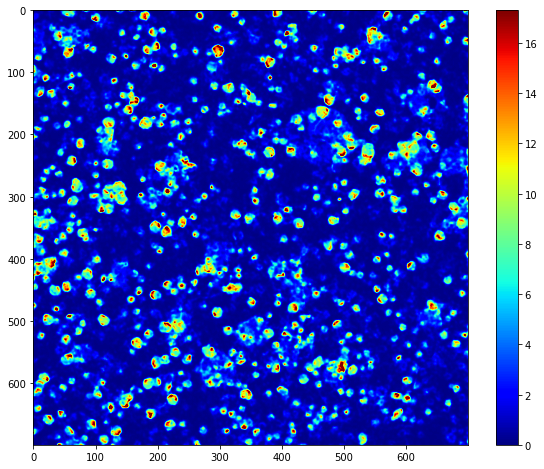

In [20]:
# perform DIMR and DeepSNiF algorithms for low SNR raw images.
Img_DIMR_DeepSNiF = deepsnif.perform_IMC_Denoise(Img_raw, n_neighbours = n_neighbours, n_iter = n_iter, window_size = window_size)
plt.figure(figsize = (10,8))
plt.imshow(Img_DIMR_DeepSNiF, vmin = 0, vmax = 0.5*np.max(Img_DIMR_DeepSNiF), cmap = 'jet')
plt.colorbar()
plt.show()